## Setup

In [1]:
import pandas as pd
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_networkx

In [2]:
import sys, os
sys.path.append('../../gnumap/')
from models.train_models import *
from scipy import optimize

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from codecarbon import OfflineEmissionsTracker
from umap_functions import *
from simulation_utils import make_roll

In [3]:
make_roll

<function simulation_utils.make_roll(c=0.6, v=4, omega=12, n_samples=2000, n_neighbours=30, a=2, b=2, scale=0.5, plot=True, features=None, standardize=True)>

In [4]:
N_NEIGHBOURS = 5

In [5]:
make_roll(c=0.6, v=4, omega=12, n_samples = 2000, n_neighbours = 30,
              a = 1, b = 1, scale=3, plot=True, features=None,
              standardize=True)
"""
X: coordinates for swissroll
t: underlying beta samples
new_data: node features
"""

(array([[-1.44799417, -0.66491815, -0.29133153],
        [ 1.14378523, -1.35795412,  0.75332247],
        [ 1.78582346,  0.78805173, -0.42649333],
        ...,
        [ 0.55216161,  1.1257918 ,  0.94079187],
        [ 0.15236396,  0.1939451 , -0.62724638],
        [ 0.0095696 ,  0.45464678, -0.41079909]]),
 array([0.82000227, 0.99830858, 0.55359398, ..., 0.6648318 , 0.06406027,
        0.12715009]),
 Data(x=[2000, 2000], edge_index=[2, 71164], edge_weight=[71164]))

'\nX: coordinates for swissroll\nt: underlying beta samples\nnew_data: node features\n'

## Data generation

In [6]:
import random
random.seed(12345)
X, t, new_data = make_roll(n_neighbours = N_NEIGHBOURS, a = 1, b = 1, scale=0.1, n_samples = 4000, features='coordinates')
# new_data is graph object

In [7]:
x = X[:,0]
y = X[:,1]
z = X[:,2]

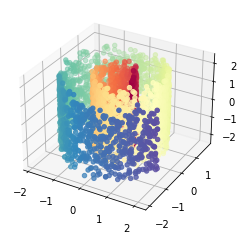

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=t, cmap='Spectral')

In [9]:
# import umap.umap_ as umap
import umap
import numpy as np
from sklearn.neighbors import kneighbors_graph

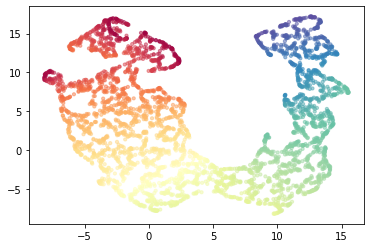

In [10]:
X = np.vstack([np.array(x),np.array(y),np.array(z)]).T
A_dist = kneighbors_graph(X, N_NEIGHBOURS, mode='distance', include_self=False)
umap_embedding = umap.UMAP(n_components=2, n_neighbors= 10, min_dist= 0.3).fit_transform(X)
plt.scatter(*umap_embedding.T, s=10, c=t, alpha=0.5, cmap='Spectral')

In [11]:
from evaluation_metric import *
neighbor_kept_ratio_eval(new_data, umap_embedding, n_neighbors=20) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(new_data.x, umap_embedding, n_points = 4000, type = 'diffusion') # global structure
corr_sp

tensor(0.8174)

0.325982498432535

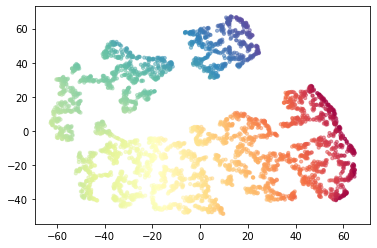

In [12]:
from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components = 2, learning_rate  = 'auto', init = 'random').fit_transform(X)
plt.scatter(*tsne_embedding.T, s = 10, c=t, alpha=0.5, cmap='Spectral')

In [13]:
neighbor_kept_ratio_eval(new_data, tsne_embedding, n_neighbors=20)
_, _, corr_sp, _ = spearman_correlation_eval(new_data.x, tsne_embedding, n_points = 4000, type = 'diffusion')
corr_sp

tensor(0.8026)

0.30876176256741267

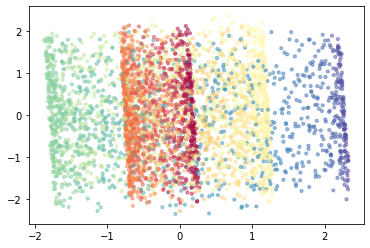

In [14]:
from sklearn.decomposition import PCA
pca_embedding = PCA(n_components = 2).fit_transform(X)
plt.scatter(*pca_embedding.T, s = 10, c=t, alpha=0.5, cmap='Spectral')

In [15]:
neighbor_kept_ratio_eval(new_data, pca_embedding, n_neighbors=20)
_, _, corr_sp, _ = spearman_correlation_eval(new_data.x, pca_embedding, n_points = 4000, type = 'diffusion')
corr_sp

tensor(0.7077)

0.6013036194698775

In [16]:
_, _, corr_sp, _ = spearman_correlation_eval(new_data.x, pca_embedding, n_points = 4000, type = 'euclidean')
corr_sp

0.8018067681872626

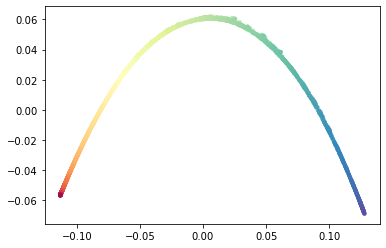

In [17]:
from pydiffmap import diffusion_map as dm
# initialize Diffusion map object.
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=200, epsilon='bgh', alpha=1.0, neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(X)
plt.scatter(*dmap.T, s = 10, c=t, alpha=0.5, cmap='Spectral')

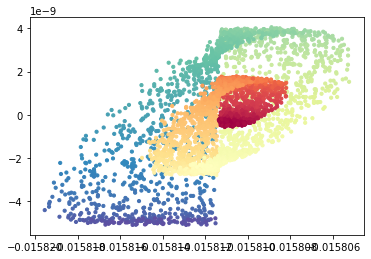

In [18]:
from diffusion_map_np import *
diff_embeddings = apply_diffusions(X, alpha = 1.0, n_eign = 2, n_diff = 5, epsilon = 50)
plt.scatter(*diff_embeddings.T, s = 10, c=t, cmap='Spectral')

In [24]:
from evaluation_metric import *
neighbor_kept_ratio_eval(new_data, diff_embeddings, n_neighbors=20)
_, _, corr_diff, _ = spearman_correlation_eval(new_data.x, diff_embeddings, type = 'diffusion')
_, _, corr_euc, _ = spearman_correlation_eval(new_data.x, diff_embeddings, type = 'euclidean')
corr_diff
corr_euc

tensor(0.0193)

0.03224984557015586

0.37784615796045884

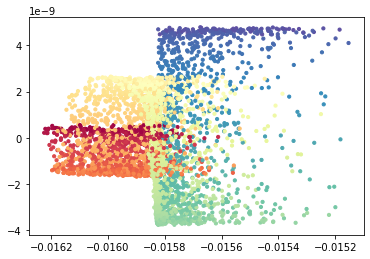

In [19]:
from diffusion_map_np import *
diff_embeddings = apply_diffusions(X, alpha = 0.5, n_eign = 2, n_diff = 5, epsilon = 50)
plt.scatter(*diff_embeddings.T, s = 10, c=t, cmap='Spectral')

In [20]:
neighbor_kept_ratio_eval(new_data, diff_embeddings, n_neighbors=20)
_, _, corr_diff, _ = spearman_correlation_eval(new_data.x, diff_embeddings, type = 'diffusion')
_, _, corr_euc, _ = spearman_correlation_eval(new_data.x, diff_embeddings, type = 'euclidean')
corr_diff
corr_euc

tensor(0.0175)

0.09793636659802156

0.07249753112806305

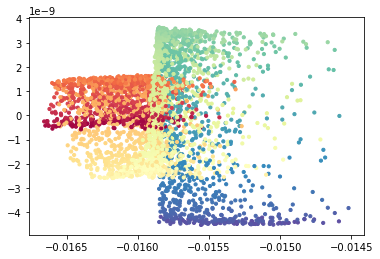

In [21]:
from diffusion_map_np import *
diff_embeddings = apply_diffusions(X, alpha = 0.0, n_eign = 2, n_diff = 5, epsilon = 50)
plt.scatter(*diff_embeddings.T, s = 10, c=t, cmap='Spectral')

In [22]:
neighbor_kept_ratio_eval(new_data, diff_embeddings, n_neighbors=20)
_, _, corr_diff, _ = spearman_correlation_eval(new_data.x, diff_embeddings, type = 'diffusion')
_, _, corr_euc, _ = spearman_correlation_eval(new_data.x, diff_embeddings, type = 'euclidean')
corr_diff
corr_euc

tensor(0.0173)

0.09728241221546735

0.07095640202002522

The number of neighbor regulates how much local information that you want to reflect on the embedding spcaces. The smaller the local n_neighbor, the more local your embedding is. 

### MLP